# Overview 

In the 10x series of notebooks, we will look at Time Series modeling in pycaret using univariate data and no exogenous variables. We will use the famous airline dataset for illustration. Our plan of action is as follows:

1. Perform EDA on the dataset to extract valuable insight about the process generating the time series. **(Covered in this notebook)**
2. Model the dataset based on exploratory analysis (univariable model without exogenous variables).
3. Use an automated approach (AutoML) to improve the performance. 

In [1]:
# Only enable critical logging (Optional)
import os
os.environ["PYCARET_CUSTOM_LOGGING_LEVEL"] = "CRITICAL"

In [2]:
def what_is_installed():
    from pycaret import show_versions
    show_versions()

try:
    what_is_installed()
except ModuleNotFoundError:
    !pip install pycaret
    what_is_installed()


System:
    python: 3.9.16 (main, Jan 11 2023, 16:16:36) [MSC v.1916 64 bit (AMD64)]
executable: C:\Users\Nikhil\.conda\envs\pycaret_dev_sktime_16p1\python.exe
   machine: Windows-10-10.0.19044-SP0

PyCaret required dependencies:
                 pip: 22.3.1
          setuptools: 65.6.3
             pycaret: 3.0.0rc9
             IPython: 8.10.0
          ipywidgets: 8.0.4
                tqdm: 4.64.1
               numpy: 1.23.5
              pandas: 1.5.3
              jinja2: 3.1.2
               scipy: 1.10.0
              joblib: 1.2.0
             sklearn: 1.2.1
                pyod: 1.0.8
            imblearn: 0.10.1
   category_encoders: 2.6.0
            lightgbm: 3.3.5
               numba: 0.56.4
            requests: 2.28.2
          matplotlib: 3.7.0
          scikitplot: 0.3.7
         yellowbrick: 1.5
              plotly: 5.13.0
             kaleido: 0.2.1
         statsmodels: 0.13.5
              sktime: 0.16.1
               tbats: 1.1.2
            pmdarima: 2.0.2


In [3]:
import time
import numpy as np
import pandas as pd

from pycaret.datasets import get_data
from pycaret.time_series import TSForecastingExperiment

In [4]:
y = get_data('airline', verbose=False)

In [5]:
# We want to forecast the next 12 months of data and we will use 3 fold cross-validation to test the models.
fh = 12 # or alternately fh = np.arange(1,13)
fold = 3

In [6]:
# Global Figure Settings for notebook ----
# Depending on whether you are using jupyter notebook, jupyter lab, Google Colab, you may have to set the renderer appropriately
# NOTE: Setting to a static renderer here so that the notebook saved size is reduced.
fig_kwargs = {
    # "renderer": "notebook",
    "renderer": "png",
    "width": 1000,
    "height": 600,
}

# Exploratory Analysis

`pycaret` Time Series Forecasting module provides a conventient interface for perform exploratory analysis using `plot_model`.

**NOTE:**
* Without an estimator argument, `plot_model` will plot using the original dataset. We will cover this in the current notebook.
* If an estimator (model) is passed to `plot_model`, the the plots are made using the model data (e.g. future forecasts, or analysis on insample residuals). We will cover this in a subsequent notebook.

Let's see how this works next. 

**First, we will plots the original dataset.**

In [7]:
eda = TSForecastingExperiment()
eda.setup(data=y, fh=fh, fig_kwargs=fig_kwargs)

,Description,Value
0,session_id,4531
1,Target,Number of airline passengers
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(144, 1)"
5,Transformed data shape,"(144, 1)"
6,Transformed train set shape,"(132, 1)"
7,Transformed test set shape,"(12, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


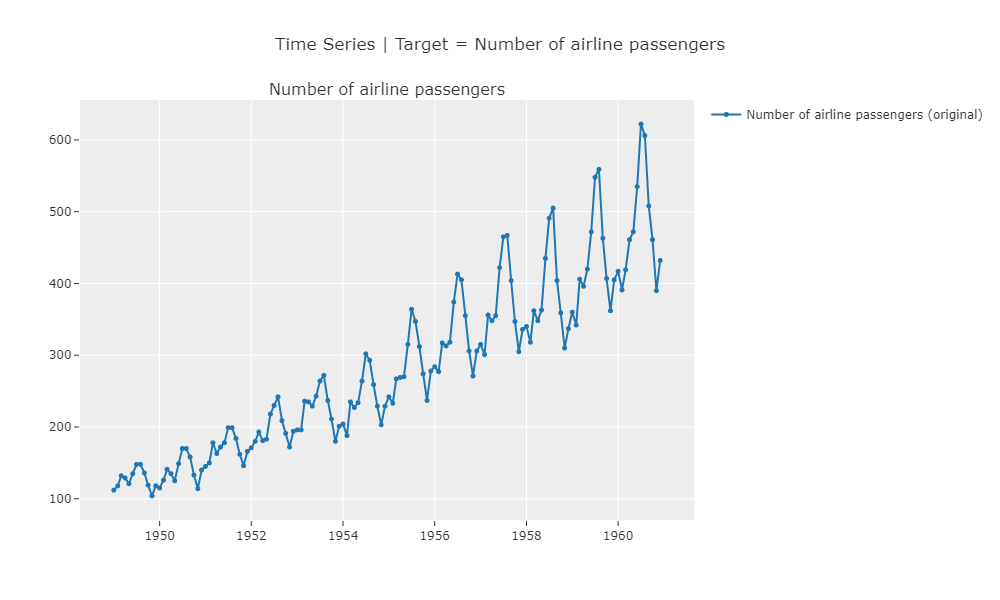

In [8]:
# NOTE: This is the same as `eda.plot_model(plot="ts")`
eda.plot_model()  

Before we explore the data further, there are a few minor things to know about how PyCaret prepares a **modeling pipeline** under the hood. The data being modeled is usually fed through an internal pipeline that has optional steps in the following order:

**Data Input (by user) >> Imputation >> Transformation & Scaling >> Model**

1. **Imputation**
  - This step is optional if data does not have missing values, and is mandatory if data has missing values. This is because many statistical tests and models can not work with missing data.
  - Although some models like `Prophet` can work with missing data, the need to run statistical tests to extract useful informaton from the data for default model settings necessitates having imputation when data has missing values. 
  

2. **Transformations and Scaling**
  - This step is optional and user should usually only enable this after evaluating the models (e.g. by performing residual analysis), or if they have specific requirements such as limiting the forecast to only positive values.
  
  
We will discuss more about imputation and transformations in in another notebook. For now, our data does not have any missing values or any transformations. So **Data Input (by user), i.e. Original data = Imputed data = Transformed data = Data fed to models**. We can verify this by plotting the internal datasets by specifying the `plot_data_type` `data_kwargs`. 

NOTE: If `plot_data_type` is not provided, each plot type has it's own default data_type that is internally determined, but the users have the ability to always overwrite using `plot_data_type`.

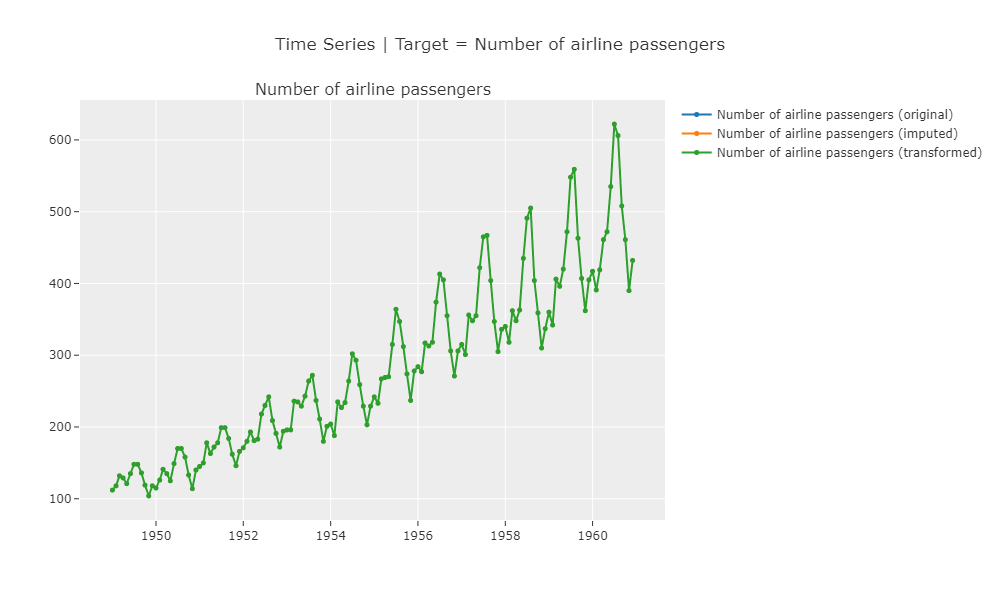

In [9]:
eda.plot_model(data_kwargs={"plot_data_type": ["original", "imputed", "transformed"]})

**Let's explore the standard ACF and PACF plots for the dataset next**

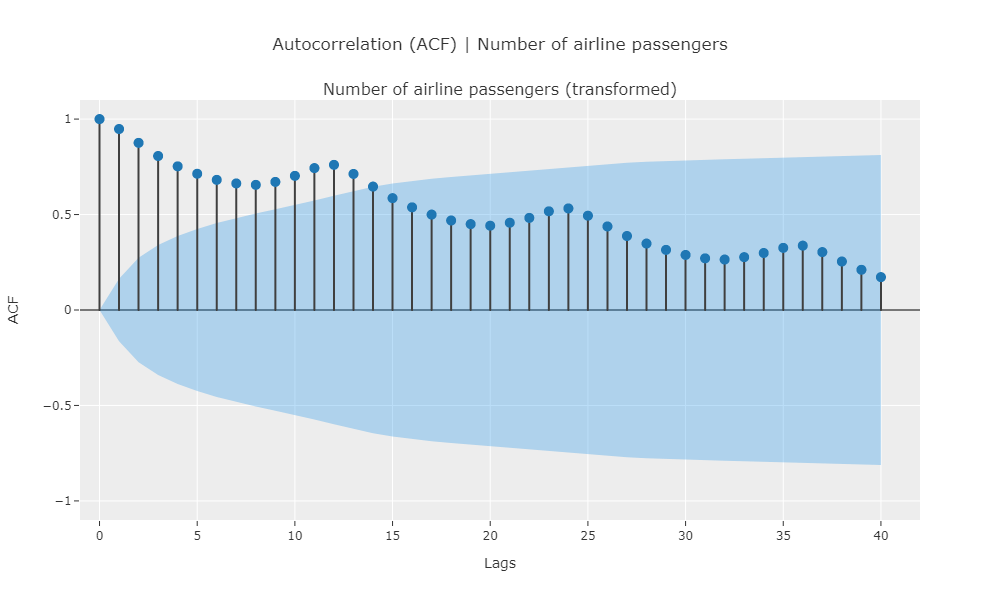

In [10]:
# ACF and PACF for the original dataset
eda.plot_model(plot="acf")

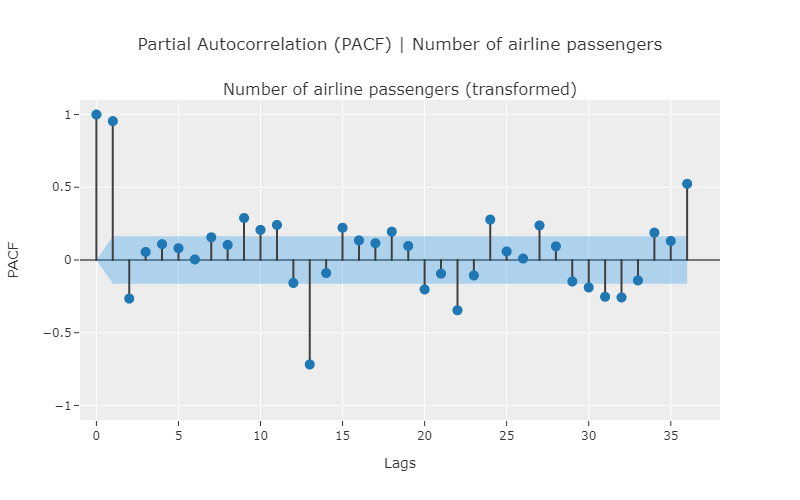

In [11]:
# NOTE: you can customize the plots with kwargs - e.g. number of lags, figure size (width, height), etc
# data_kwargs such as `nlags` are passed to the underlying function that gets the ACF values
# figure kwargs such as `fig_size` & `template` are passed to plotly and can have any value that plotly accepts
eda.plot_model(plot="pacf", data_kwargs={'nlags':36}, fig_kwargs={'height': 500, "width": 800})

**Users may also wish to explore the spectrogram or the FFT which are very useful for studying the frequency components in the time series.**

For example:
- Peaking at f =~ 0 can indicating wandering behavior characteristic of a random walk that needs to be differenced. This could also be indicative of a stationary ARMA process with a high positive phi value.
- Peaking at a frequency and its multiples is indicative of seasonality. The lowest frequency in this case is called the fundamental frequency and the inverse of this frequency is the seasonal period for the model.

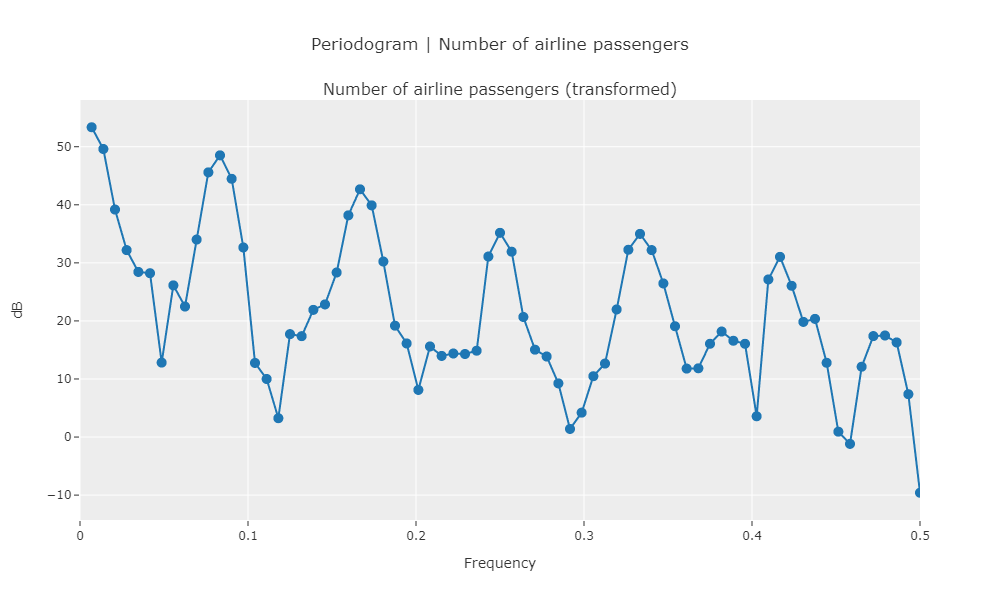

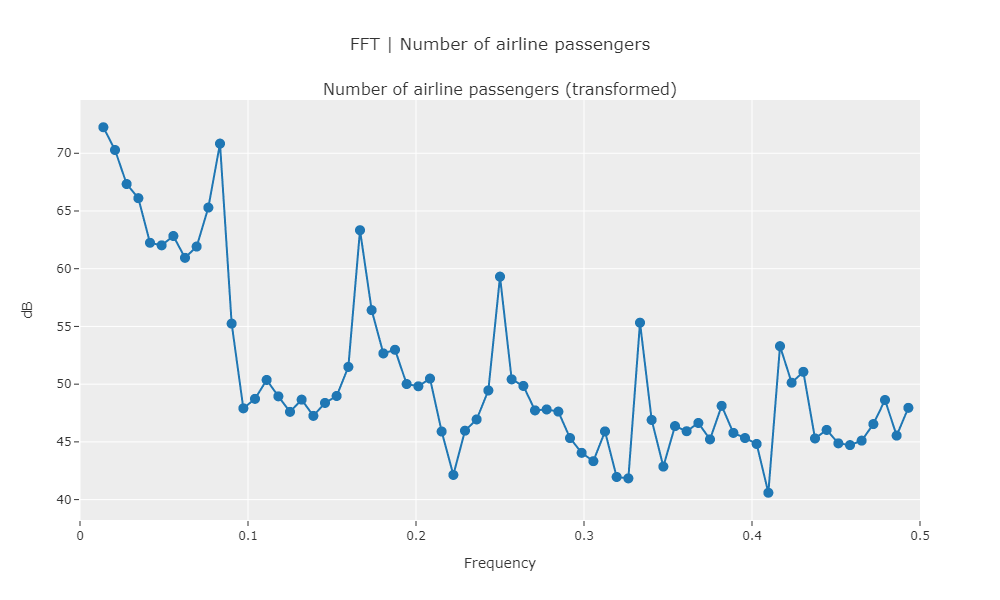

In [12]:
eda.plot_model(plot="periodogram")
eda.plot_model(plot="fft")

**In the plots above, we notice**

1. Peaking at f ~= 0 indicating that we need to difference the data.
2. Peaking at f = 0.0833, 0.1677, 0.25, 0.3333, 0.4167. All these are multiple of 0.0833. Hence 0.0833 is the fundamental frequency and the seasonal period is 1/0.0833 = 12.

**Alternately, the `diagnostics` plot provides all these details in a convenient call.**

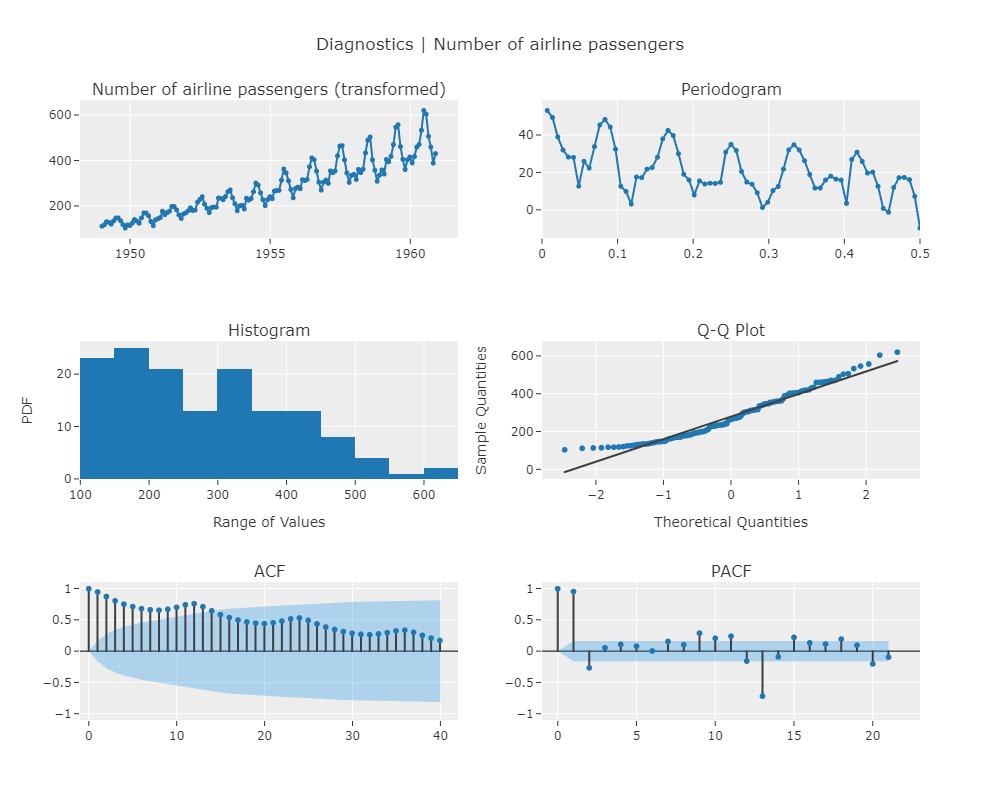

In [13]:
eda.plot_model(plot="diagnostics", fig_kwargs={"height": 800, "width": 1000})

Our diagnosutic plots indicated the need to difference and the presence of a seasonal period of 12. **Let's see what happends when we remove this from the model. What other characteristics are left in the model that would need to be taken care of?** 

This can be achieved through the difference plots. Along with the difference plots, we will plot the corresponding ACF, PACF and Periodogram for further diagnostics.

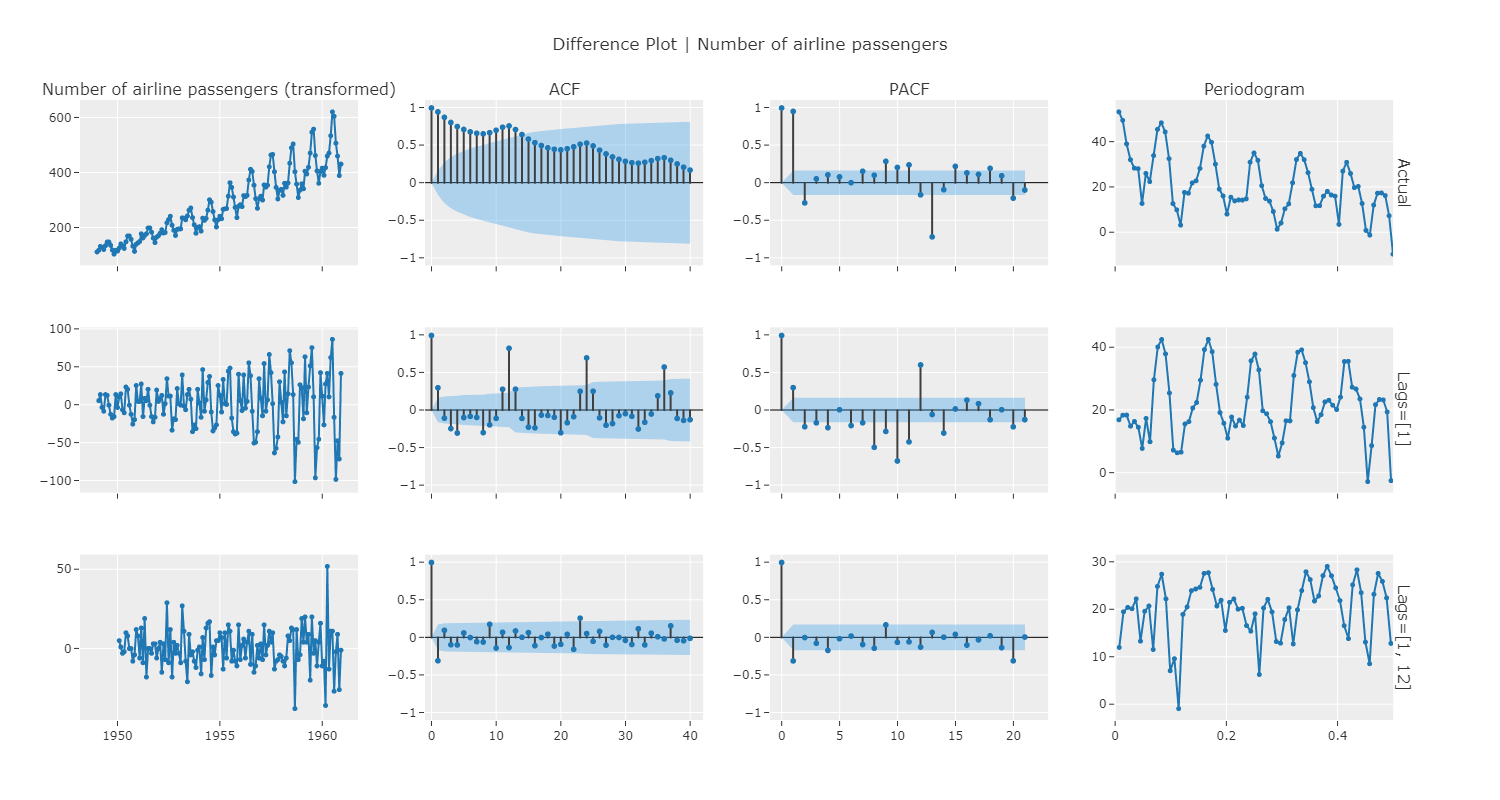

In [14]:
# Row 1: Original
# Row 2: d = 1
# Row 3: First (d = 1) then (D = 1, s = 12)
#   - Corresponds to applying a standard first difference to handle trend, and
#     followed by a seasonal difference (at lag 12) to attempt to account for
#     seasonal dependence.
# Ref: https://www.sktime.org/en/stable/api_reference/auto_generated/sktime.transformations.series.difference.Differencer.html
eda.plot_model(
    plot="diff",
    data_kwargs={"lags_list": [[1], [1, 12]], "acf": True, "pacf": True, "periodogram": True},
    fig_kwargs={"height": 800, "width": 1500}
)


# ## NOTE: Another way to specify differences is using order_list
# # Row 1: Original
# # Row 2: d = 1
# # Row 3: d = 2
# eda.plot_model(
#     plot="diff",
#     data_kwargs={
#         "order_list": [1, 2],
#         "acf": True, "pacf": True, "periodogram": True
#     },
#     fig_kwargs={"height": 600, "width": 1200}
# )

**Observations:**

1. In the second row, we have only removed the wandering behavior by taking a first difference. This can be seen in the ACF plot (extended autocorrelations are gone) and Periodogram (peaking at f =~ 0 is squished). The ACF (preaking at seasonal period of 12 and its multiples) and PACF (peaking at fundamental frequency of 0.0833 and its multiples) still show the seasonal behavior.
2. In the third row, we have taken first difference followed by a seasonal difference of 12. Now, we can see that the peaking at seasonal multiples is gone from both ACF and Periodogram. There is still a little bit of autoregresssive properties that we have not taken care of but by looking at the PACF, maybe p=1 seems like a reasonable value to use (most lags after that are insignificant).

**Conclusion**
* If you were modeling this with ARIMA, the model to try would be **ARIMA(1,1,0)x(0,1,0,12)**.
* Other models could use this information appropriately. For example, reduced regression models could remove the trend and seasonality of 12 (i.e. make the data stationary) before modeling the rest of the autoregressive properties. Luckily, the `pycaret` time series module will take care of this internally.


**Let's plot the Time Series Decomposition next (another classical diagnostic plot)**

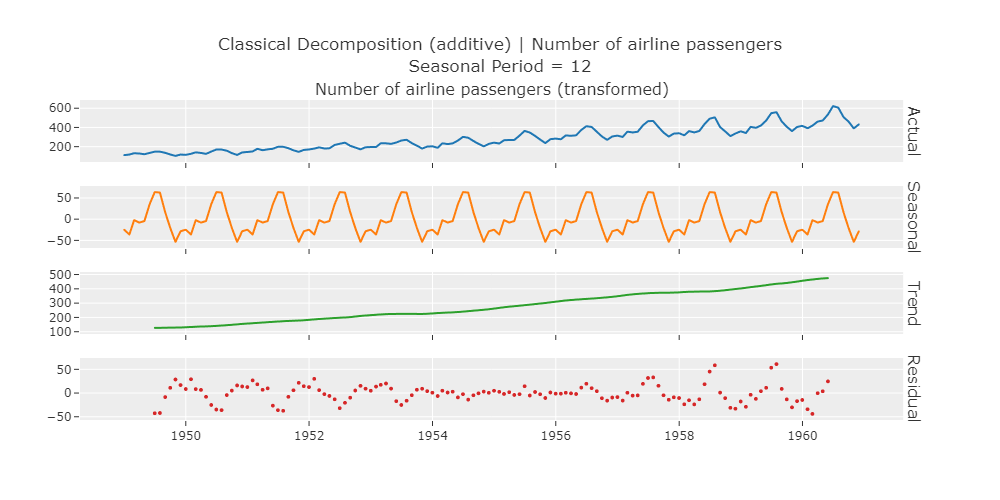

In [15]:
# First, classical decomposition
# By default the seasonal period is the one detected during setup - 12 in this case.
eda.plot_model(plot="decomp", fig_kwargs={"height": 500})

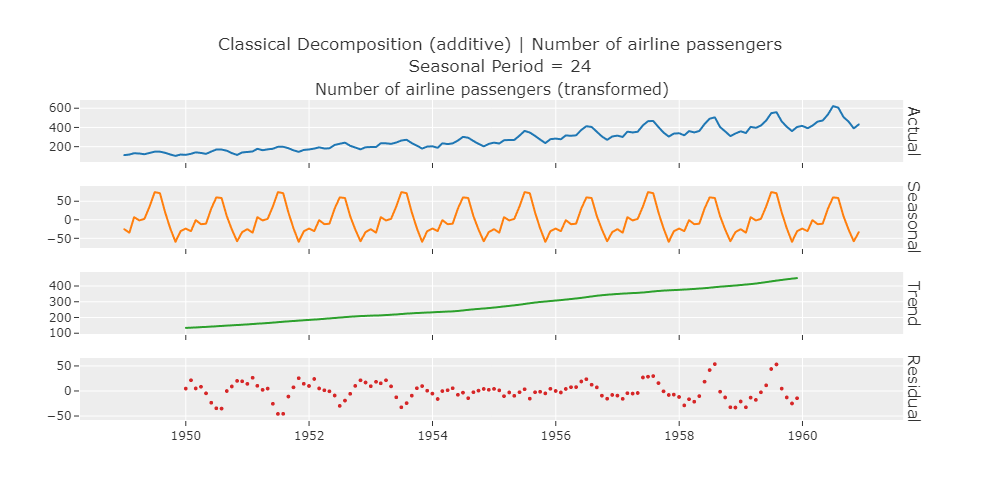

In [16]:
# Users can change the seasonal period to explore what is best for this model.
eda.plot_model(plot="decomp", data_kwargs={'seasonal_period': 24}, fig_kwargs={"height": 500})

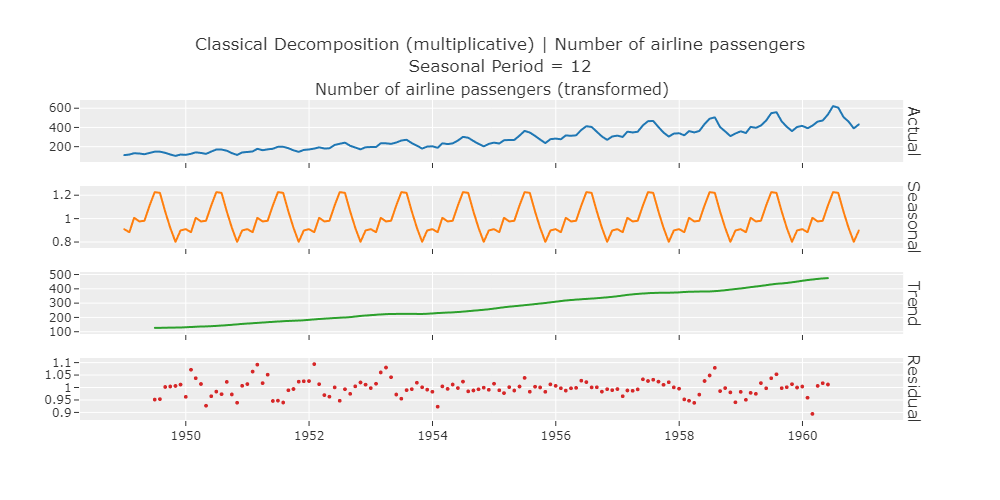

In [17]:
# Users may wish to customize the decomposition, for example, in this case multiplicative seasonality
# probably makes more sense since the magnitide of the seasonality increase as the time progresses
eda.plot_model(plot="decomp", data_kwargs={'type': 'multiplicative'}, fig_kwargs={"height": 500})

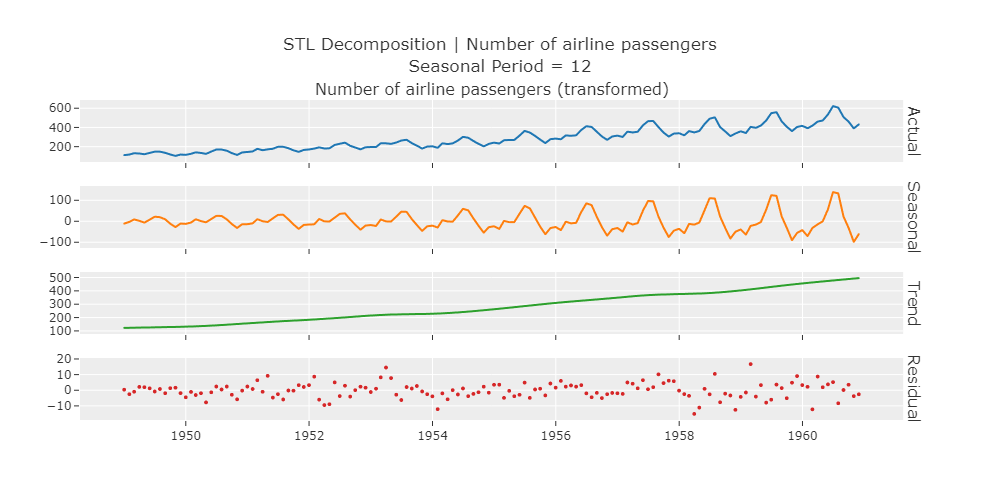

In [18]:
# Users can also plot STL decomposition
# Reference: https://otexts.com/fpp2/stl.html
eda.plot_model(plot="decomp_stl", fig_kwargs={"height": 500})

**Let us look at the various splits of the data used for modeling next.**

**NOTE:**
* In time series, we can not split the data randomly since there is serial correlation in the data and using future data to predict past data will result in leakage. Hence the temporal dependence must be maintained when splitting the data. 
* Users may wish to refer to this for more details: 
  - https://github.com/pycaret/pycaret/discussions/1761
  - https://robjhyndman.com/hyndsight/tscv/
  - https://topepo.github.io/caret/data-splitting.html#data-splitting-for-time-series

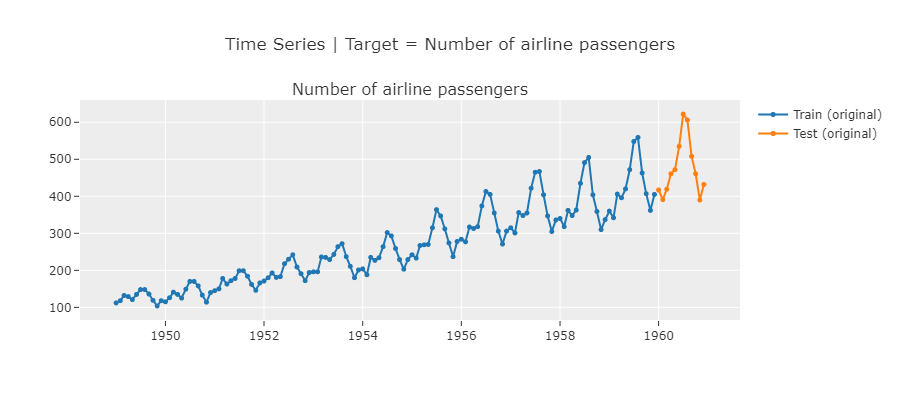

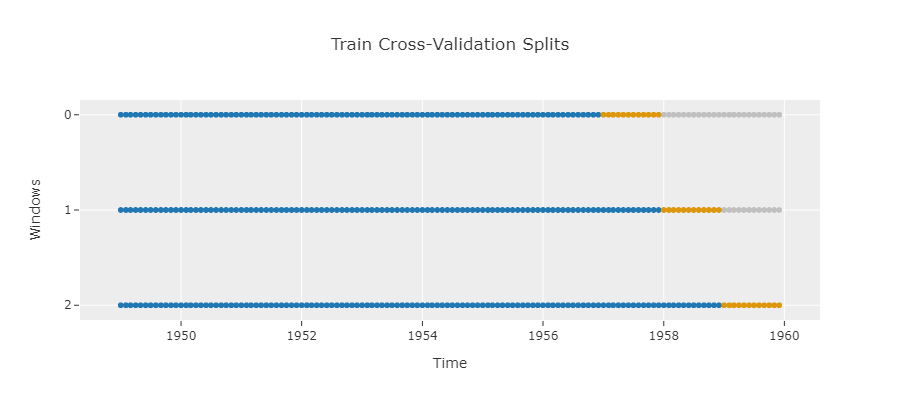

In [19]:
# Show the train-test splits on the dataset
# Internally split - len(fh) as test set, remaining used as test set
eda.plot_model(plot="train_test_split", fig_kwargs={"height": 400, "width": 900})

# Show the Cross Validation splits inside the train set
# The blue dots represent the training data for each fold.
# The orange dots represent the validation data for each fold
eda.plot_model(plot="cv", fig_kwargs={"height": 400, "width": 900})

# Statistical Tests

Statistical Testing is another important part of time series modeling. This can be achieved easily in pycaret using `check_stats`.

**Options are:**
* 'summary',
* 'white_noise'
* 'stationarity'
* 'adf'
* 'kpss'
* 'normality'
* 'all' 

By default the statistics are run on the "transformed" data, but similar to plots, the user has the abiliy to set this to another data type using the `data_type` argument. e.g. `eda.check_stats(test="summary", data_type = "original")`

In [20]:
# Summary Statistics
eda.check_stats(test="summary")

,Test,Test Name,Data,Property,Setting,Value
0,Summary,Statistics,Transformed,Length,,144.000000
1,Summary,Statistics,Transformed,# Missing Values,,0.000000
2,Summary,Statistics,Transformed,Mean,,280.298611
3,Summary,Statistics,Transformed,Median,,265.500000
4,Summary,Statistics,Transformed,Standard Deviation,,119.966317
5,Summary,Statistics,Transformed,Variance,,14391.917201
6,Summary,Statistics,Transformed,Kurtosis,,-0.364942
7,Summary,Statistics,Transformed,Skewness,,0.583160
8,Summary,Statistics,Transformed,# Distinct Values,,118.000000


In [21]:
# Stationarity tests (ADF and KPSS)
# NOTE: Users can also just run a single test by passing either 'adf' or 'kpss' to `check_stats`
eda.check_stats(test='stationarity')

,Test,Test Name,Data,Property,Setting,Value
0,Stationarity,ADF,Transformed,Stationarity,{'alpha': 0.05},False
1,Stationarity,ADF,Transformed,p-value,{'alpha': 0.05},0.99188
2,Stationarity,ADF,Transformed,Test Statistic,{'alpha': 0.05},0.815369
3,Stationarity,ADF,Transformed,Critical Value 1%,{'alpha': 0.05},-3.481682
4,Stationarity,ADF,Transformed,Critical Value 5%,{'alpha': 0.05},-2.884042
5,Stationarity,ADF,Transformed,Critical Value 10%,{'alpha': 0.05},-2.57877
6,Stationarity,KPSS,Transformed,Trend Stationarity,{'alpha': 0.05},True
7,Stationarity,KPSS,Transformed,p-value,{'alpha': 0.05},0.1
8,Stationarity,KPSS,Transformed,Test Statistic,{'alpha': 0.05},0.09615
9,Stationarity,KPSS,Transformed,Critical Value 10%,{'alpha': 0.05},0.119


The ADF tests shows that the data is not stationary and we saw this in the plots as well (clear trend and seasonal behavior)

In [22]:
# Ljung-Bx test to tests of white noise (whether the data is uncorrelated or not)
eda.check_stats(test='white_noise')

,Test,Test Name,Data,Property,Setting,Value
0,White Noise,Ljung-Box,Transformed,Test Statictic,"{'alpha': 0.05, 'K': 24}",1606.083817
1,White Noise,Ljung-Box,Transformed,Test Statictic,"{'alpha': 0.05, 'K': 48}",1933.155822
2,White Noise,Ljung-Box,Transformed,p-value,"{'alpha': 0.05, 'K': 24}",0.0
3,White Noise,Ljung-Box,Transformed,p-value,"{'alpha': 0.05, 'K': 48}",0.0
4,White Noise,Ljung-Box,Transformed,White Noise,"{'alpha': 0.05, 'K': 24}",False
5,White Noise,Ljung-Box,Transformed,White Noise,"{'alpha': 0.05, 'K': 48}",False


The Ljung-Box tests indicates that the data is not white noise - again something that was clearly visible in the data

In [23]:
# Users have the option to customize the tests such as change the alpha value.
eda.check_stats(test='kpss', alpha = 0.2)

,Test,Test Name,Data,Property,Setting,Value
0,Stationarity,KPSS,Transformed,Trend Stationarity,{'alpha': 0.2},False
1,Stationarity,KPSS,Transformed,p-value,{'alpha': 0.2},0.1
2,Stationarity,KPSS,Transformed,Test Statistic,{'alpha': 0.2},0.09615
3,Stationarity,KPSS,Transformed,Critical Value 10%,{'alpha': 0.2},0.119
4,Stationarity,KPSS,Transformed,Critical Value 5%,{'alpha': 0.2},0.146
5,Stationarity,KPSS,Transformed,Critical Value 2.5%,{'alpha': 0.2},0.176
6,Stationarity,KPSS,Transformed,Critical Value 1%,{'alpha': 0.2},0.216


Alternately, all the above tests can be done in one shot by not passing any test type.

In [24]:
eda.check_stats()

,Test,Test Name,Data,Property,Setting,Value
0,Summary,Statistics,Transformed,Length,,144.0
1,Summary,Statistics,Transformed,# Missing Values,,0.0
2,Summary,Statistics,Transformed,Mean,,280.298611
3,Summary,Statistics,Transformed,Median,,265.5
4,Summary,Statistics,Transformed,Standard Deviation,,119.966317
5,Summary,Statistics,Transformed,Variance,,14391.917201
6,Summary,Statistics,Transformed,Kurtosis,,-0.364942
7,Summary,Statistics,Transformed,Skewness,,0.58316
8,Summary,Statistics,Transformed,# Distinct Values,,118.0
9,White Noise,Ljung-Box,Transformed,Test Statictic,"{'alpha': 0.05, 'K': 24}",1606.083817


**That's it for this notebook. In the next notebook, we will see how we can start to model this data.**